In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

### 시퀀스와 시계열 데이터 이해하기

##### 다변량 시계열 : 각 시간 단위마다 여러개의 값을 가지는 데이터
##### 일변량 시계열 : 시간에 따른 값이 하나만 존재하는 데이터

##### 트렌드 : 시간에 따라 y축의 값이 상승, 하강, 일정과 같이 특징이 나타나는 것
##### 계절성 : 시간에 따라 일정한 간격으로 반복되는 패턴
##### 지기상관 : 어떤 이벤트 후에 예측 가능한 행동이 나타나는 것
##### 잡음 : 시례열에 있는 랜덤한 변동, 잡음은 예측을 어렵게 한다

In [32]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [20]:
def trend(time, slope=0):
    return slope * time

In [21]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
    np.cos(season_time * 2 * np.pi),
    1 / np.exp(3 * season_time))

In [22]:
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [23]:
def noise(time, noise_level=1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [24]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, .05)
amplitude = 15
slope = 0.09
noise_level = 6

In [25]:
series = baseline + trend(time, slope) \
                  + seasonality(time, period=365, amplitude=amplitude)

In [26]:
# 시계열 만들기
series += noise(time, noise_level, seed=42)

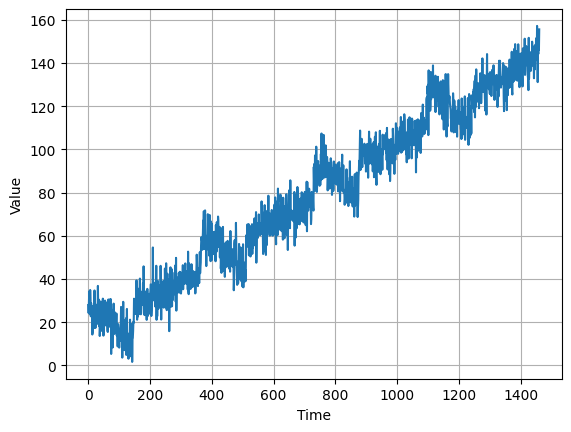

In [34]:
# 잡음 추가
plot_series(time, series, format="-", start=0, end=None)

##### 훈련세트와 검증 세트, 테스트 세트로 나누기
##### 시계열 데이터의 앞부분 1000개를 훈련용, 그리고 나머지를 검증용 데이터로 분리

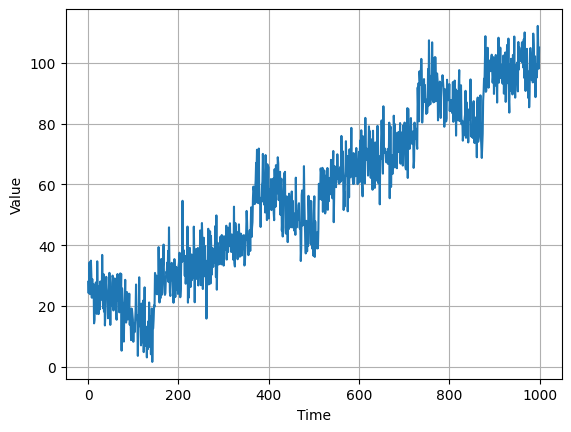

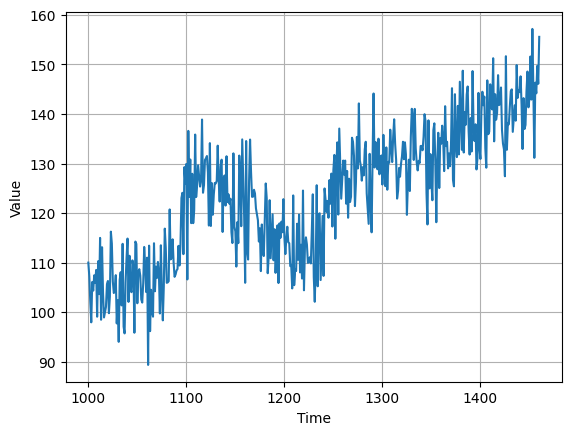

In [38]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time_train, x_train)
plt.show()

plot_series(time_valid, x_valid)
plt.show()

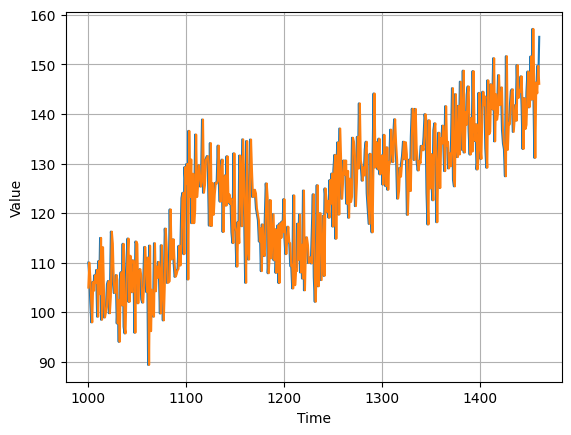

In [39]:
naive_forecast = series[split_time - 1: -1]
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

#### 손실함수
##### MSE : 오차 제곱의 평균, 추측값에 대한 정확성을 측정하는 방법
#### 회귀지표
##### MAE : 오차 절대값의 평균, 회귀평가를 위한 지표로 주로 쓰인다. 기계 학습 모델의 퀄리티를 요약하고 평가하기 위한 여러 메트릭 중 하나라고 할 수 있다.MSE와 마찬가지로 0에 가까울수록 좋은 모델이라고 할 수 있다.

In [51]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

76.47491
6.8992977


##### 이동 평균 :  어떤 것이 방향성을 가지고 움직일 때, 이동하면서 구해지는 평균을 뜻합니다. 즉, 동적으로 변화하는 것에는 어디든 이동평균을 적용할 수 있습니다. 주가데이터 또한, 1차원적인 방향성을 가지고 이동하기 때문에 이동평균을 적용할 수 있습니다. 

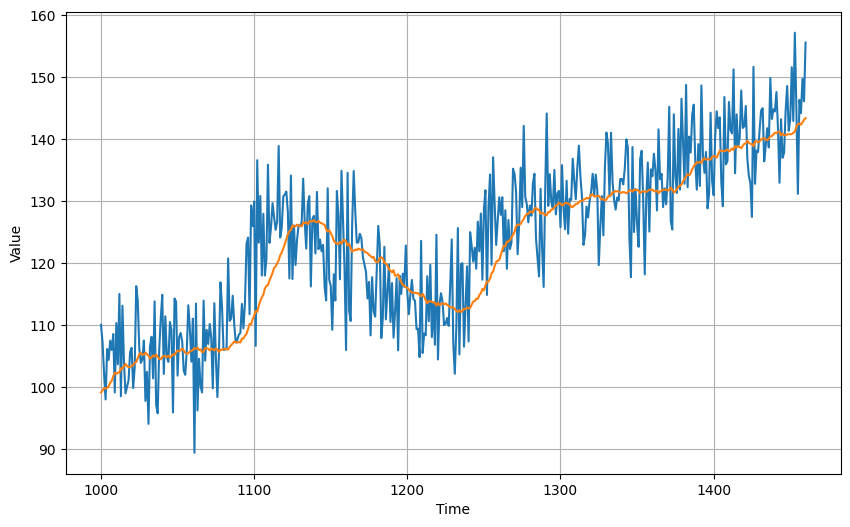

In [52]:
# window_size : 마지막 몇 개 값의 평균을 사용하여 예측
def moving_average_forcast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

moving_avg = moving_average_forcast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [53]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

49.04444
5.532835


##### 

In [54]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

In [55]:
diff_moving_avg = \
    moving_average_forcast(diff_series, 50)[split_time - 365 -50 :]

diff_moving_avg_plus_smooth_path = \
    moving_average_forcast(series[split_time - 370:-360], 10) + \
    diff_moving_avg

In [57]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_path).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_path).numpy())

40.902336
5.136001


##### 처음예측 했을 때보다 이동평균으로 예측을 했을 경우가 MSE,MAE가 더 낮다 즉 성능이 향상되었다.